In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow.keras.backend as K

In [2]:

class CustomLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x
    
    
def load_model_weights():
    custom_objects = {"CustomLayer": CustomLayer}
    reconstructed_encoder = tf.keras.models.load_model( "./models/encoderModel.keras")
    reconstructed_vae =tf.keras.models.load_model("./models/vaeModel.keras",
                                                  custom_objects={"CustomLayer": CustomLayer},)
    
    reconstructed_decoder = tf.keras.models.load_model(
    "./models/decoderModel.keras", )
    
    
    return (reconstructed_encoder,reconstructed_decoder,reconstructed_vae)

def preprocess(img_path):
    import cv2
    import numpy as np
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # gray = 255 - img

    gray = cv2.resize(gray, (28, 28))
    cv2.imwrite('gray'+ img_path, gray)
    img = gray / 255.0
    img = np.array(img).reshape(28, 28, 1)
    return img

def predict_image(img,encoder,decoder,img_w=28, img_h=28):
    mu, _, _ = encoder.predict(tf.expand_dims(img,axis=0))
    sample_vector = np.array([mu[0]])
    decoded_example = decoder.predict(sample_vector)
    decoded_example_reshaped = decoded_example.reshape(img_w, img_h)
    plt.subplot(1, 2, 2)
    plt.title("Generated")
    plt.imshow(decoded_example_reshaped)
    
    real = img
    plt.subplot(1, 2, 1)
    plt.title("Real")
    plt.imshow(real)
    
    return decoded_example_reshaped

In [3]:
encoder,decoder,vae = load_model_weights()

In [4]:
ig1 = preprocess('./stage (1).png')

1/1 [==============================] - 0s 11ms/step


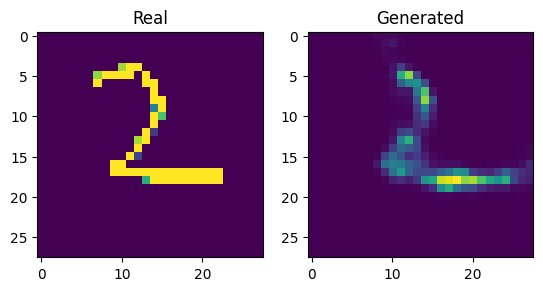

In [6]:
img = predict_image(ig1,encoder,decoder,28,28)